In [1]:
# imports
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import f1_score

In [2]:
! pip install tensorflow-model-optimization
import tensorflow as tf
from tensorflow.keras import models
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 5.5 MB/s eta 0:00:00


# Methods for creating data set

In [3]:
# Generate square
def add_square(img, center, width):
  start_point = (center[0]-width, center[1]-width)
  end_point   = (center[0]+width, center[1]+width)
  cv2.rectangle(img, start_point, end_point, (255, 255, 255),cv2.FILLED)

In [4]:
# generate sample
def create_data_sample(num_shapes, height, width):
  img = np.zeros((height, width, 3))
  for i in range(num_shapes):
    x = int(np.random.rand()*width)
    y = int(np.random.rand()*height)
    if np.random.rand() > 0.5:
      radius = random.uniform(0.06, 0.12) # random circle radius multiplier
      cv2.circle(img, (x,y), int(np.ceil(width*radius)), (255, 255, 255), cv2.FILLED)
      data_shape = 0
      # Show circle pos
      # cv2.circle(label, (x,y), int(np.ceil(width*0.02)), (1, 1, 1), cv2.FILLED)
    else:
      data_shape = 1
      side = random.uniform(0.07, 0.2) # random square side multiplier
      add_square(img, (x,y), int(np.ceil(width*0.6*side)))
  return img, data_shape


In [5]:
# def test_batch(num_shapes, height, width):
#   img, data_shape = create_data_sample(num_shapes, height, width)
#   return np.expand_dims(img,0), data_shape

In [6]:
# def grayscale_image(img):
#   return np.expand_dims((img[:,:,0] + img[:,:,1] + img[:,:,2])/3,2)

In [7]:
# # (128,128,1) --> (128,128,3)
# def to_three_channels(img):
#   return np.squeeze(np.stack((img,img,img), 2))

In [8]:
def show_sample(img, shape):
  class_names = ['Circle', 'Square'] # Training shapes list
  plt.imshow(img)
  plt.title(class_names[shape], fontsize=20)
  # the pos info
  # axis[1].imshow(to_three_channels(label))

In [9]:
def show_sample_group(img_list, shape_list, count):
  table_height = int(count / 4) + 1
  labels = ["Circle", "Square"]
  for i in range(count):
    plt.subplot(table_height, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_list[i], cmap=plt.cm.binary)
    plt.xlabel(labels[shape_list[i]])

In [10]:
# def show_batch(img, shape):
#   show_sample(img[0,:,:,:], shape)

# Method for applying a new model - MobileNetv1

In [11]:

def create_mobilenetv1_model(input_shape=(96, 96, 1), alpha=0.25):
    input_tensor = Input(shape=input_shape)

    # MobileNetV1 architecture
    base_model = tf.keras.applications.MobileNet(input_shape=(None, None, 3), include_top=False, weights='imagenet', alpha=alpha)
    for layer in base_model.layers:
        layer.trainable = False  # Freeze pre-trained layers

    x = Conv2D(3, (1, 1), padding='same', activation='relu')(input_tensor)  # Convert single-channel to three channels
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)

    output_tensor = Dense(2, activation='softmax')(x)  # Adjust the output layer based on your task

    model = models.Model(inputs=input_tensor, outputs=output_tensor)

    return model
# #

# Sample

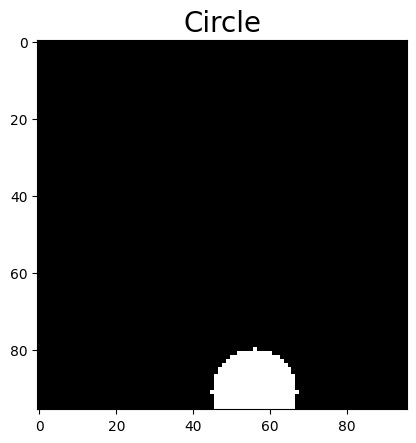

In [12]:
img_shape = (96, 96, 1) #resolution changed fron 320x240 into 96x96
img, data_shape = create_data_sample(1, img_shape[0], img_shape[1]) # data smaple with 1 shape, height, width
show_sample(img, data_shape)

# Model Training

In [16]:
# Training model type setup
from tensorflow.keras.layers import Dense
#l2 = keras.regularizers.l2(1e-5)
l2 = None


model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),  # Adjust kernel size as needed
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
])


model.summary()

model_mn1 = create_mobilenetv1_model()
model_mn1.summary()
# #

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 94, 94, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 30976)             0         
                                                                 
 dense_4 (Dense)             (None, 2)                

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 96, 96, 3)         6         
                                                                 
 mobilenet_0.25_224 (Functi  (None, None, None, 256)   218544    
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (None, 256)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                                 
Total params: 219064 (855.72 KB)
Trainable params: 520 (2.0

In [17]:
# Generate data sample for teaching model
teachingDataSize = 300

x_list = []
x_type = []
for i in range(teachingDataSize):
  x, y  = create_data_sample(1, img_shape[0], img_shape[1])
  x_list.append(x[:, :, 0:1])
  x_type.append(y)
x_list = np.array(x_list)
x_type = np.array(x_type)

# save dataset

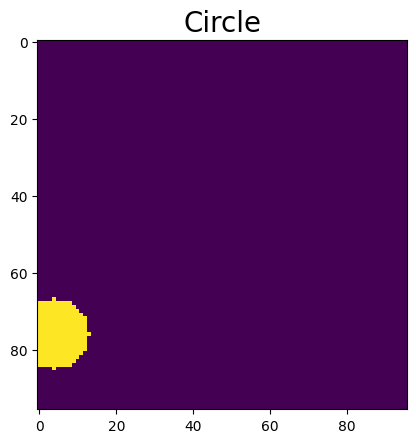

In [18]:
i = 0
show_sample(x_list[i], x_type[i])

In [19]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
x_list = x_list.reshape((-1, 96, 96, 1))
##

# Compile the model
model_mn1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# #

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) # check GPU avaible devices

Num GPUs Available:  1


In [20]:
# Load pregenerated dataset


In [21]:
# train model
%whos
# model_history stores history of trained model (accuracy, loss) OF THE SECOND MODEL! TAKE NOTE!
model_history = model.fit(x_list, x_type, epochs=10, batch_size=10)
model_history1 = model_mn1.fit(x_list, x_type, epochs=5, batch_size=64)
# #
# save trained model
model.save('saved_model/my_model')

model_mn1.save('saved_model/mn1_model')
# #

Variable                   Type          Data/Info
--------------------------------------------------
Conv2D                     type          <class 'keras.src.layers.<...>olutional.conv2d.Conv2D'>
Dense                      type          <class 'keras.src.layers.core.dense.Dense'>
GlobalAveragePooling2D     type          <class 'keras.src.layers.<...>.GlobalAveragePooling2D'>
Input                      function      <function Input at 0x795b25415e10>
add_square                 function      <function add_square at 0x795b0fee0c10>
create_data_sample         function      <function create_data_sample at 0x795bac1d9a20>
create_mobilenetv1_model   function      <function create_mobilene<...>_model at 0x795b0fee1510>
cv2                        module        <module 'cv2' from '/usr/<...>ackages/cv2/__init__.py'>
data_shape                 int           0
f1_score                   function      <function f1_score at 0x795b103d8430>
i                          int           0
img           

# Load pretrained model below

In [22]:
model = tf.keras.models.load_model('saved_model/mn1_model')

# Testing Accuracy, Loss & F1 score

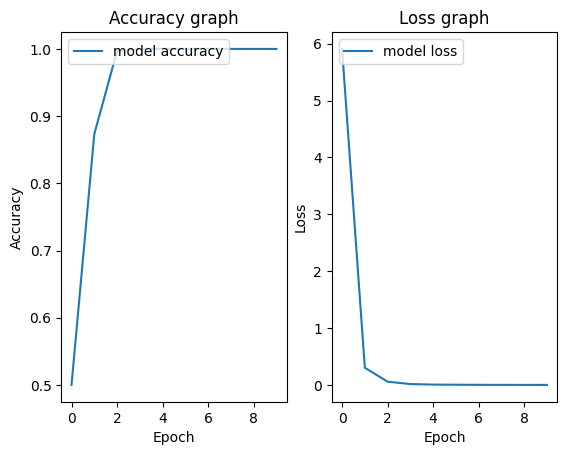

In [23]:
# plotting accuracy and loss

# accuracy
plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'])
plt.title('Accuracy graph') # accuracy per epoch
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['model accuracy'], loc='upper left')

# loss
plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'])
plt.title('Loss graph') # loss per epoch
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['model loss'], loc='upper left')

In [24]:
# Generate data sample for testing model
testingDataSize = 10000

x_list_test = []
y_list_test = []
for i in range(testingDataSize):
  x, y  = create_data_sample(1, img_shape[0], img_shape[1])
  x_list_test.append(x[:, :, 0:1])
  y_list_test.append(y)
x_list_test = np.array(x_list_test)
y_list_test = np.array(y_list_test)

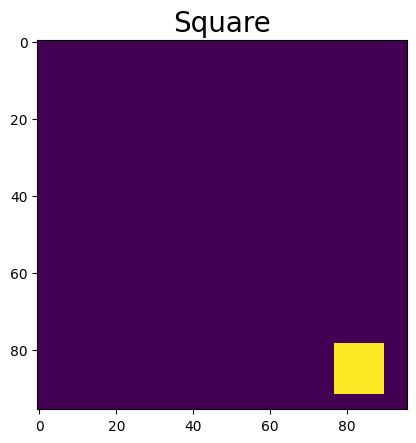

In [25]:
# Sampling testing data set

show_sample(x_list_test[0], y_list_test[0])

In [26]:
# Success rate

probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(x_list_test)
predicted_labels = []
success_rate = 0
for i in range(testingDataSize):
  if(np.argmax(predictions[i]) == y_list_test[i]):
      success_rate += 1
  predicted_labels.append(np.argmax(predictions[i]))
# show_sample_group(x_list_test, predicted_labels, testingDataSize)
print("Success rate: ", (success_rate / testingDataSize) * 100, "%")

# F1 score
f1 = f1_score(y_list_test, predicted_labels) * 100 # (reality, predictions)
print(f"F1 Score: {f1} %")

model_mn1.evaluate(x_list_test, y_list_test)

313/313 [==============================] - 3s 7ms/step
Success rate:  74.48 %
F1 Score: 72.12756662297947 %
313/313 [==============================] - 6s 12ms/step - loss: 0.5088 - accuracy: 0.7448


[0.5088445544242859, 0.7447999715805054]

# Model Export


In [27]:
for layer in model.layers:
    layer.trainable = False
model.summary()
model.save('frozen_model.h5')

for layer in model_mn1.layers:
    layer.trainable = False

model_mn1.save('frozen_mobilenetv1_model.h5')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 96, 96, 3)         6         
                                                                 
 mobilenet_0.25_224 (Functi  (None, None, None, 256)   218544    
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (None, 256)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                                 
Total params: 219064 (855.72 KB)
Trainable params: 0 (0.00 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Quantization is a process of reducing the precision of the weights and activations in a model, typically from 32-bit floating-point to 8-bit integer. This can significantly reduce the model size, making it more suitable for deployment on memory-constrained devices like microcontrollers.

To quantize a model for TensorFlow Lite, you can follow these steps:

    Train the Model:
        Train your model as usual, making sure it performs well on your task.

    Quantize the Model:
        After training, apply quantization to the model. TensorFlow provides tools for quantizing a model using the TensorFlow Lite Converter.

Here's an example of how you can quantize your model:

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming you have your trained model
model = models.load_model('frozen_model.h5')

# Convert the model to TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Save the quantized model to a file
with open('quantized_model.tflite', 'wb') as f:
    f.write(tflite_quantized_model)

""""# Assuming you have your trained MobileNetV1 model
model_mn1 = models.load_model('frozen_mobilenetv1_model.h5')

# Convert the MobileNetV1 model to TensorFlow Lite format with quantization
converter_mn1 = tf.lite.TFLiteConverter.from_keras_model(model_mn1)
converter_mn1.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quantized_model_mn1 = converter_mn1.convert()

# Save the quantized MobileNetV1 model to a file
with open('quantized_model_mn1.tflite', 'wb') as f:
    f.write(tflite_quantized_model_mn1)
""""




In [29]:
! apt-get -qq install xxd
! xxd -i quantized_model.tflite > trimera_model.c
! xxd -i quantized_model_mn1.tflite > trimera_model_mn1.c
! ls -l
! zip model.zip trimera_model.c
! zip model_mn1.zip trimera_model_mn1.c

total 6000
-rw-r--r-- 1 root root 1065576 Dec 11 16:39 frozen_mobilenetv1_model.h5
-rw-r--r-- 1 root root 1051832 Dec 11 16:39 frozen_model.h5
-rw-r--r-- 1 root root  279000 Dec 11 16:40 quantized_model_mn1.tflite
-rw-r--r-- 1 root root  279000 Dec 11 16:40 quantized_model.tflite
drwxr-xr-x 1 root root    4096 Dec  4 14:27 sample_data
drwxr-xr-x 4 root root    4096 Dec 11 16:39 saved_model
-rw-r--r-- 1 root root 1720595 Dec 11 16:40 trimera_model.c
-rw-r--r-- 1 root root 1720603 Dec 11 16:40 trimera_model_mn1.c
  adding: trimera_model.c (deflated 79%)
  adding: trimera_model_mn1.c (deflated 79%)


In [30]:
! ls -l


total 6712
-rw-r--r-- 1 root root 1065576 Dec 11 16:39 frozen_mobilenetv1_model.h5
-rw-r--r-- 1 root root 1051832 Dec 11 16:39 frozen_model.h5
-rw-r--r-- 1 root root  363937 Dec 11 16:40 model_mn1.zip
-rw-r--r-- 1 root root  363918 Dec 11 16:40 model.zip
-rw-r--r-- 1 root root  279000 Dec 11 16:40 quantized_model_mn1.tflite
-rw-r--r-- 1 root root  279000 Dec 11 16:40 quantized_model.tflite
drwxr-xr-x 1 root root    4096 Dec  4 14:27 sample_data
drwxr-xr-x 4 root root    4096 Dec 11 16:39 saved_model
-rw-r--r-- 1 root root 1720595 Dec 11 16:40 trimera_model.c
-rw-r--r-- 1 root root 1720603 Dec 11 16:40 trimera_model_mn1.c
